In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer.mpl import showDataContainerAsMatrix
from pygimli.viewer import pv

In [2]:
# We load the data file from the example repository. It represents a crosshole
# data set published by Kuras et al. (2009) in the frame of the ALERT project.

In [3]:
# data = ert.load("crosshole3d.dat")
data = pg.getExampleData("ert/crosshole3d.dat")
print(data)

22/03/23 - 13:00:21 - pyGIMLi - INFO - Looking for ert/crosshole3d.dat in gimli-org/example-data/


Data: Sensors: 36 data: 753, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [4]:
# There are 36 electrodes, each 9 in four boreholes, and 1256 data that are
# resistances only. Therefore we first compute the geometric factors and then
# the apparent resistivities, of which we plot the last few values.
#

found 47 x values
found 45 y values


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1fa32fc2280>)

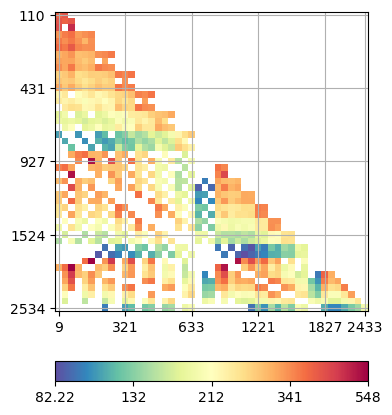

In [5]:
data["k"] = ert.geometricFactors(data, dim=3)
data["rhoa"] = data["r"] * data["k"]
ab = data["a"] * 100 + data["b"]
mn = data["m"] * 100 + data["n"]
showDataContainerAsMatrix(data, ab, mn, "rhoa", cMap="Spectral_r")

In [6]:
# %%%
# We determine the x and z positions and create a regular grid with a spacing
# of 5xm that contains the electrodes as nodes. This is not necessary but
# improves quality of the forward response. Around the boreholes there is 0.5m
# space and all mesh cells have the marker 2.
#

In [7]:
# %%%
# We first extract the borehole locations, i.e. the x and y positions of the
# electrodes. From these we create a rectangle with 40% boundary and marker 2
# and add the borehole positions to it.
#

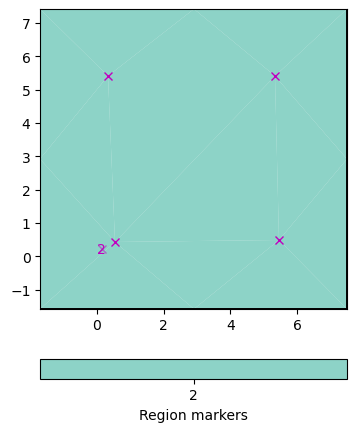

In [8]:
elPosXY = np.unique(np.column_stack([pg.x(data), pg.y(data)]), axis=0)
rect = mt.createRectangle(pnts=elPosXY, minBBOffset=1.4, marker=2)
for elpos in elPosXY:
    rect.createNode(*elpos, 0)

ax, cb = pg.show(rect)
ax.plot(*elPosXY.T, "mx")

In [9]:
# %%%
# From this PLC, we create a mesh using a maximum cell size.
# We add an outer (modelling) boundary.
#

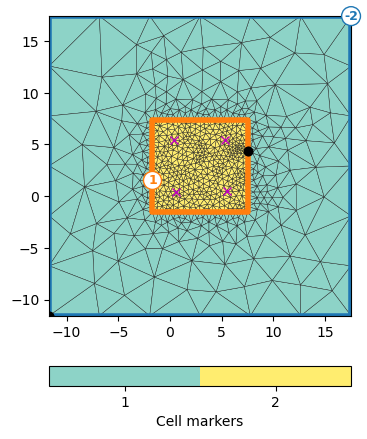

In [10]:
bnd = 5
rectMesh = mt.createMesh(rect, quality=34.5, area=.2)
mesh2d = mt.appendTriangleBoundary(
    rectMesh, boundary=bnd, isSubSurface=False, marker=1)
ax, cb = pg.show(mesh2d, markers=True, showMesh=True)
ax.plot(*elPosXY.T, "mx")

In [11]:
# %%%
# We create a vertical discretization vector with dense spacing in the range of
# the electrodes and a coarser discretization above and below.
#

In [12]:
dTop, dBot = 3.5, 10.7
dzIn, dzOut = 0.3, 0.7
zTop = -np.arange(0, dTop, dzOut)  # the upper layer
zMid = -np.arange(dTop, dBot, dzIn)  # the middle
zBot = -np.arange(dBot, dBot+bnd+.1, dzOut)  # the lower layer
zVec = np.concatenate([zTop, zMid, zBot])
print(zVec)
mesh = mt.createMesh3D(mesh2d, zVec, pg.core.MARKER_BOUND_HOMOGEN_NEUMANN,
                       pg.core.MARKER_BOUND_MIXED)

print(mesh)
for c in mesh.cells():
    cd = -c.center().z()  # center depth
    if cd < dTop or cd > dBot:
        c.setMarker(1)

[ -0.   -0.7  -1.4  -2.1  -2.8  -3.5  -3.8  -4.1  -4.4  -4.7  -5.   -5.3
  -5.6  -5.9  -6.2  -6.5  -6.8  -7.1  -7.4  -7.7  -8.   -8.3  -8.6  -8.9
  -9.2  -9.5  -9.8 -10.1 -10.4 -10.7 -11.4 -12.1 -12.8 -13.5 -14.2 -14.9
 -15.6]
Mesh: Nodes: 24864 Cells: 47448 Boundaries: 5840


We estimate an error using default values, i.e. 3% relative error and an
absolute error of 100uV at an assumed current of 100mA which is almost zero.
Inversion is run with less weight into the vertical direction.

In [13]:
data["err"] = ert.estimateError(data)
mgr = ert.Manager(data)
mgr.invert(mesh=mesh, zWeight=0.2, verbose=True)
# mgr.showResult(cMin=100, cMax=500)

22/03/23 - 13:00:23 - pyGIMLi - INFO - Found 2 regions.
22/03/23 - 13:00:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/03/23 - 13:00:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/03/23 - 13:00:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/03/23 - 13:00:34 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 194253 Cells: 379584 Boundaries: 481480
22/03/23 - 13:00:43 - pyGIMLi - INFO - Use median(data values)=242.661030606489
22/03/23 - 13:00:43 - pyGIMLi - INFO - Created startmodel from forward operator: 19176 [242.661030606489,...,242.661030606489]
22/03/23 - 13:00:43 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001FA362BDD60>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001FA362BDAE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001FA362AE940>
min/max (data): 82.22/548
min/max (error): 3%/3%
min/max (start model): 243/243
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 10.12 (dPhi = 92.9%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 2.37 (dPhi = 66.18%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 0.81 (dPhi = 33.61%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.81)                   #
#############

19176 [550.5557016227107,...,48.86430549162109]

In [16]:
pd = mgr.paraDomain
pd["res"] = mgr.model
pl, _ = pg.show(pd, label="res", style="surface", cMap="Spectral_r", #hold=True,
                filter={"slice": dict(normal=[-1, -1, 0], origin=[2, 2, -6])})
# pv.drawMesh(pl, pd, label="res", style="surface", cMap="Spectral_r",
#             filter={"threshold": dict(value=500, scalars="res")})
pl.camera_position = "yz"
pl.camera.azimuth = 20
pl.camera.elevation = 20
pl.camera.zoom(1.2)
pl.show()

In [15]:
# %%%
# References
# ----------